# Stock Price Analysis and Prediction using LSTM: Netflix (NFLX)


## Introduction

This project focuses on the analysis and prediction of stock prices using historical data from Netflix (NFLX). Stock price prediction is a vital task in financial analysis, helping traders, investors, and analysts make informed decisions. With the rise of machine learning and deep learning techniques, it is possible to build models that can predict future stock prices based on historical data trends. In this project, we will leverage an LSTM (Long Short-Term Memory) model, a type of recurrent neural network (RNN), to predict Netflix stock prices. The analysis will cover Exploratory Data Analysis (EDA), feature engineering, model training, and evaluation, along with forecasting future stock prices.

## About the Dataset

The dataset used in this analysis contains historical stock price information for Netflix (NFLX). It includes daily stock prices with the following columns:

- **Date:** The date of the stock data (format: YYYY-MM-DD).
- **Open:** The opening price of the stock on that date.
- **High:** The highest price reached by the stock on that date.
- **Low:** The lowest price reached by the stock on that date.
- **Close:** The closing price of the stock on that date.
- **Adj Close:** The adjusted closing price, considering corporate actions like dividends and stock splits.
- **Volume:** The number of shares traded on that date.

### Key Characteristics of the Dataset:

- **Time Span:** The dataset spans multiple years of Netflix's stock price history, providing valuable insight into long-term trends and short-term fluctuations.
- **Granularity:** The data is recorded at a daily frequency, allowing detailed analysis of the day-to-day stock price movement.
- **Missing Values:** Missing values are handled using forward fill to maintain continuity in the time series data.

This dataset allows for both time series analysis and the application of machine learning and deep learning models to forecast future stock prices. The main goal is to predict future closing prices, which can provide insights into potential stock movements and help in decision-making processes for investors.

### Analysis Goals

- **Exploratory Data Analysis (EDA):** To understand the distribution, trends, and correlations in the data.
- **Feature Engineering:** To extract relevant features for the model.
- **Modeling:** To build an LSTM model for predicting future stock prices based on historical data.
- **Evaluation:** To assess the model’s performance using metrics such as RMSE.
- **Forecasting:** To predict future stock prices and provide confidence intervals for the predictions.

This comprehensive approach will combine data analysis and modeling techniques to provide a robust stock price prediction model for Netflix.


## Importing the Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

## Load the Dataset

In [2]:
data = pd.read_csv('NFLX.csv', parse_dates=['Date'])

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [4]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200
1008,2022-02-04,407.309998,412.769989,396.640015,410.170013,410.170013,7782400


## Handle the Missing Values

In [5]:
data.fillna(method='ffill', inplace=True)

## Exploratory Data Analysis

### Time Series Plot of Close Prices

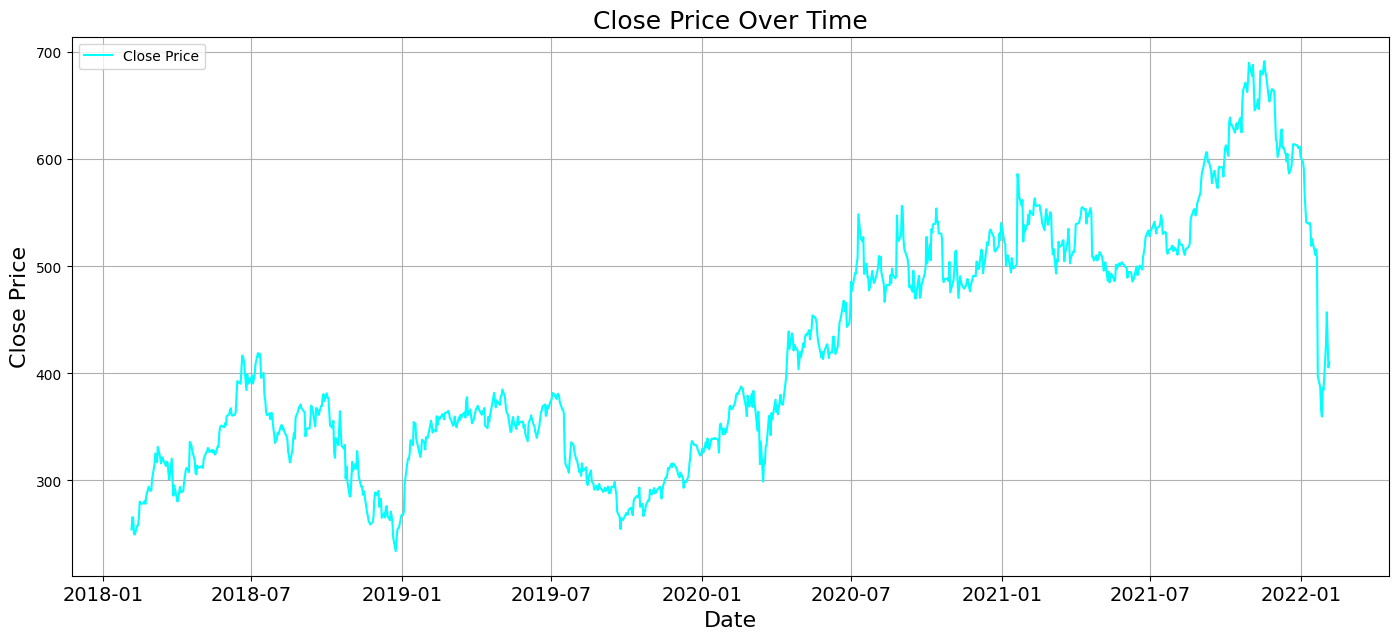

In [6]:
plt.figure(figsize=(17, 7))
plt.plot(data['Date'], data['Close'], color='cyan', label='Close Price')
plt.title('Close Price Over Time', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price', fontsize=16)
plt.xticks(fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### Distribution of Daily High Prices

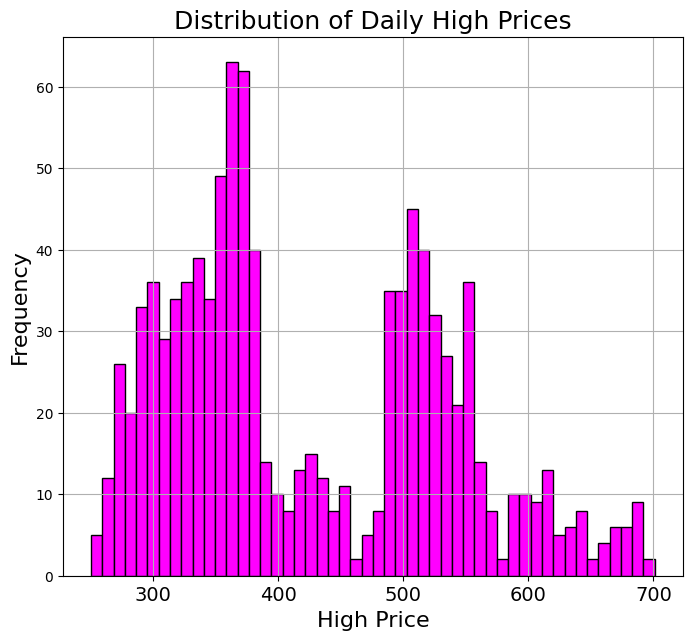

In [7]:
plt.figure(figsize=(8, 7))
plt.hist(data['High'], bins=50, color='magenta', edgecolor='black')
plt.title('Distribution of Daily High Prices', fontsize=18)
plt.xlabel('High Price', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
plt.grid(True)
plt.show()

### Monthly Average Close Prices

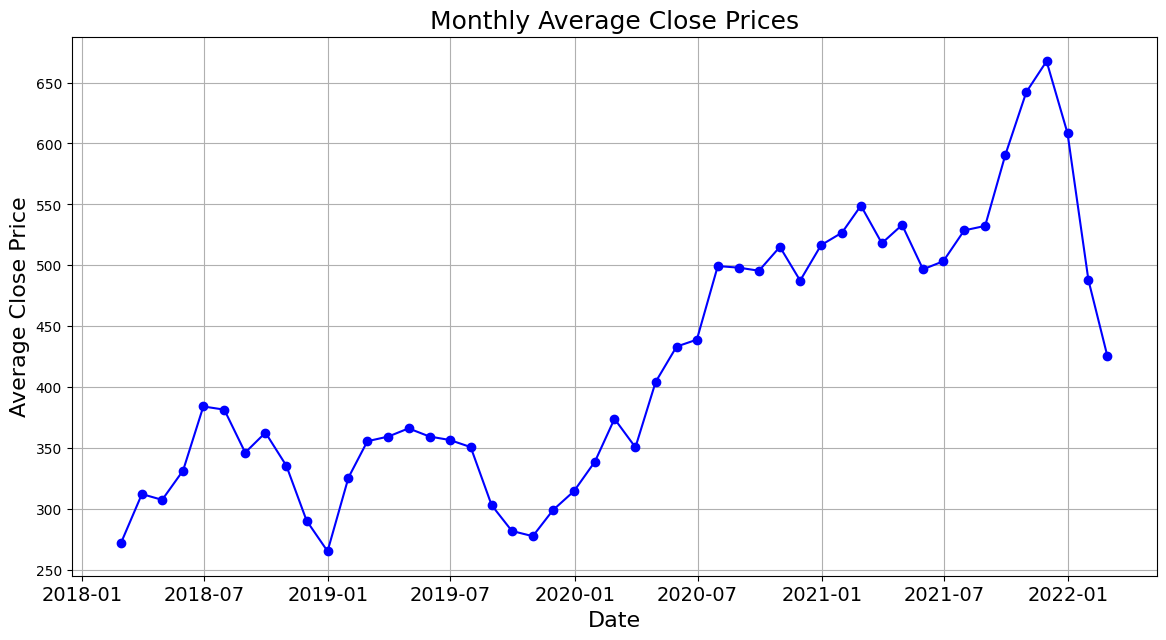

In [8]:
monthly_avg_close = data.resample('M', on='Date')['Close'].mean()
plt.figure(figsize=(14, 7))
plt.plot(monthly_avg_close.index, monthly_avg_close.values, color='blue', marker='o')
plt.title('Monthly Average Close Prices', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Average Close Price', fontsize=16)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
plt.grid(True)
plt.show()

### Correlation Matrix of Features

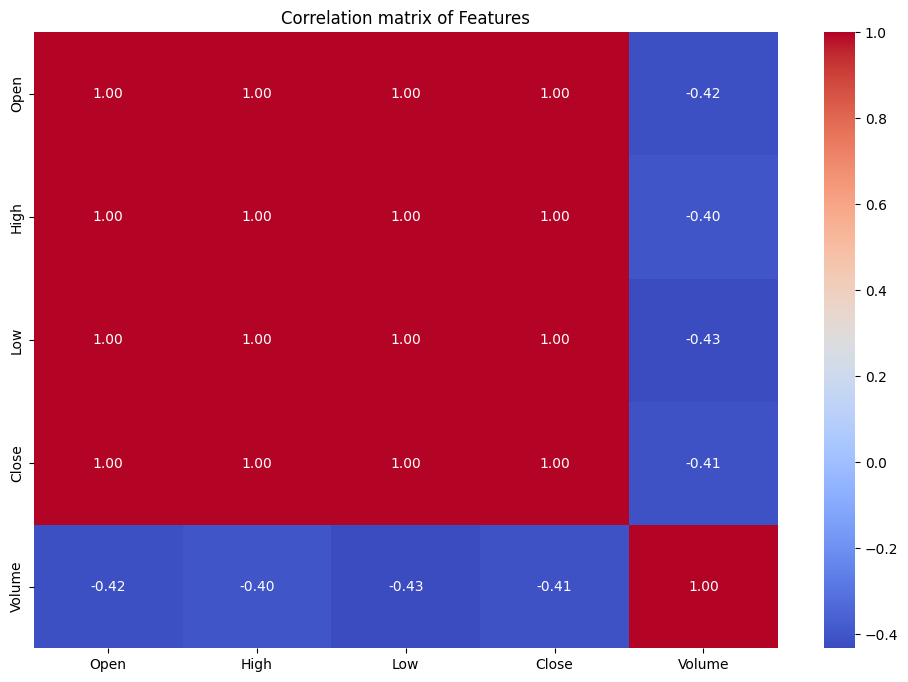

In [9]:
import seaborn as sns
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix of Features')
plt.show()

## Feature Engineering

In [10]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

## Use Close Price as Target Variable

In [11]:
features = ['Open', 'High', 'Low', 'Volume', 'Year', 'Month', 'Day']
target = 'Close'

## Prepare Data

In [12]:
X = data[features].values
y = data[target].values

## Scale Features

In [13]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

## Create Sequences for LSTM

In [14]:
def create_sequences(data, target, time_step):
    X_seq, y_seq = [], []
    for i in range(len(data) - time_step):
        X_seq.append(data[i:i + time_step])
        y_seq.append(target[i + time_step])
    return np.array(X_seq), np.array(y_seq)
time_step = 60
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_step)

## Split the Data into train and test sets

In [15]:
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

## Build LSTM Model

In [16]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

## Train the Model with early stopping

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0386 - val_loss: 0.0030
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0025 - val_loss: 0.0064
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0

## Make Predictions

In [18]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


## Calculate Rmse

In [19]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE:{rmse}')

RMSE:20.450865710907518


## Calculate Prediction Intervals

In [20]:
residuals = y_test.flatten() -y_pred.flatten()
std_dev = np.std(residuals)
ci_factor = 1.96 #for 95% CI

upper_bound = y_pred.flatten() + ci_factor * std_dev
lower_bound = y_pred.flatten() - ci_factor * std_dev

## Plot Historical Data and Predictions with Confiedence Intervals

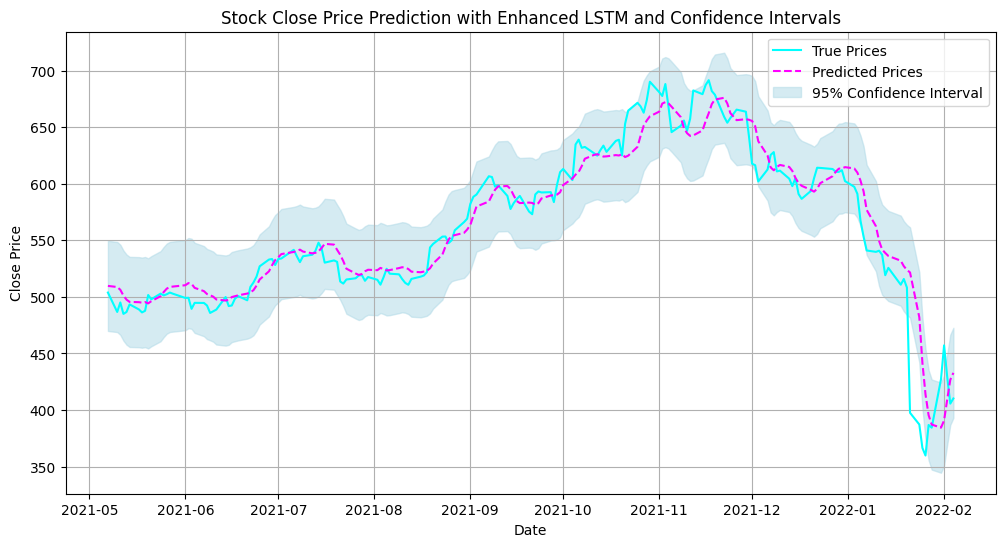

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'].iloc[-len(y_test):], y_test, label='True Prices', color='cyan')
plt.plot(data['Date'].iloc[-len(y_test):], y_pred, label='Predicted Prices', color='magenta', linestyle='--')
plt.fill_between(data['Date'].iloc[-len(y_test):], lower_bound, upper_bound, color='lightblue', alpha=0.5, label='95% Confidence Interval')
plt.title('Stock Close Price Prediction with Enhanced LSTM and Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

## Forecast Future Prices

In [22]:
def forecast_future(model, last_sequence, n_steps, scaler_X, scaler_y):
    forecast = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        # Predict the next value
        prediction = model.predict(current_sequence[np.newaxis, :, :])
        forecast.append(prediction[0, 0])
        
        # Update current_sequence with the new prediction
        current_sequence = np.roll(current_sequence, shift=-1, axis=0)
        current_sequence[-1, -1] = prediction  # Update the target feature with prediction

    forecast = np.array(forecast)
    return scaler_y.inverse_transform(forecast.reshape(-1, 1)).flatten()

## Prepare for future forecasting

In [23]:
last_sequence = X_scaled[-time_step:]
n_future_steps = 30
forecast_scaled = forecast_future(model, last_sequence, n_future_steps, scaler_X, scaler_y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

## Create Future Dates

In [24]:
last_date = data['Date'].iloc[-1]
future_dates = [last_date +pd.DateOffset(days=x) for x in range(1, n_future_steps +1)]

## Print out Forecast Values for Debugging

In [25]:
print(f"Forecast values: {forecast_scaled}")

Forecast values: [430.49457 498.03165 567.7963  619.7607  653.60864 671.2133  681.7323
 684.399   683.72675 676.6904  666.37396 658.9315  658.9555  657.9412
 656.35547 648.65485 635.4299  624.2843  615.6757  614.56036 618.3227
 620.24817 618.1973  614.34174 607.6143  602.5869  599.4484  595.3225
 593.4203  595.4825 ]


## Plot the forecast with hypothetical confiedence intervals

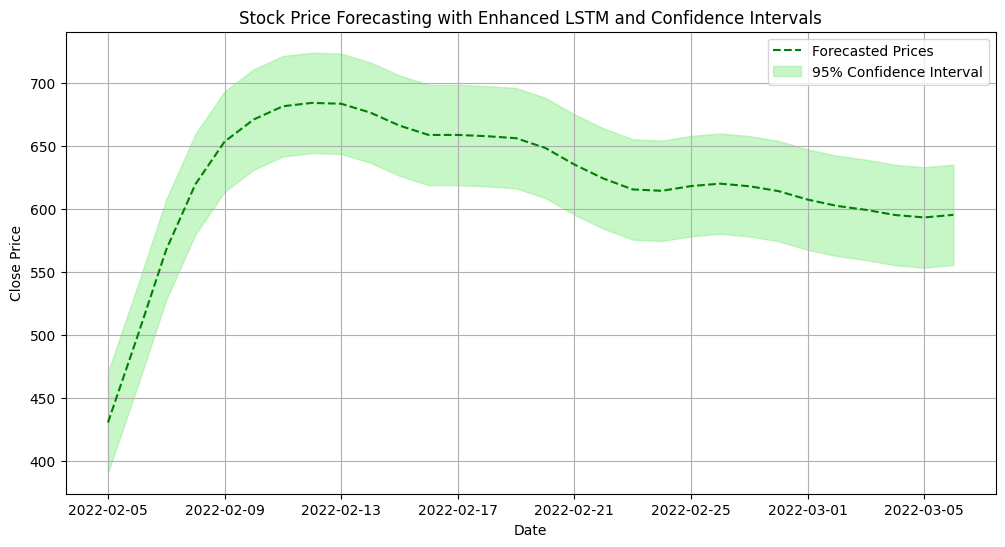

In [26]:
forecast_std_dev = std_dev  # Hypothetical std deviation for forecast
forecast_upper_bound = forecast_scaled + ci_factor * forecast_std_dev
forecast_lower_bound = forecast_scaled - ci_factor * forecast_std_dev
plt.figure(figsize=(12, 6))
plt.plot(future_dates, forecast_scaled, label='Forecasted Prices', color='green', linestyle='--')
plt.fill_between(future_dates, forecast_lower_bound, forecast_upper_bound, color='lightgreen', alpha=0.5, label='95% Confidence Interval')
plt.title('Stock Price Forecasting with Enhanced LSTM and Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

The forecasted prices are plotted along with the hypothetical confidence intervals, providing a visual forecast of future stock prices with an estimate of uncertainty.

### Conclusion

In this analysis, we conducted a comprehensive approach to forecasting Netflix's stock prices using historical data. The process included data preprocessing, exploratory data analysis (EDA), model building, and forecasting:

1. **Data Preprocessing**:
   - **Missing Values**: Missing values in the dataset were handled using forward fill (`data.fillna(method='ffill', inplace=True)`), ensuring continuity in the time series data without introducing gaps.
   - **Feature Engineering**: New features were created to extract temporal information (Year, Month, Day) from the `Date` column, and the data was scaled for model compatibility.

2. **Exploratory Data Analysis (EDA)**:
   - **Time Series Plot**: Visualized the historical closing prices to identify trends and fluctuations over time.
   - **Distribution Plots**: Analyzed the distribution of daily high prices and monthly average closing prices to understand the variability and trends.
   - **Correlation Matrix**: Illustrated the relationships between different features (Open, High, Low, Close, Volume), highlighting potential correlations that could impact predictions.

3. **Model Building**:
   - **Enhanced LSTM Model**: Built an advanced Long Short-Term Memory (LSTM) model with dropout layers for regularization, designed to capture sequential dependencies in the stock price data.
   - **Training and Evaluation**: Trained the model with early stopping to prevent overfitting and evaluated its performance using RMSE. The model's ability to predict stock prices was further validated with confidence intervals.

4. **Forecasting**:
   - **Future Price Predictions**: Utilized the trained LSTM model to forecast stock prices for the next 30 days. The forecasts were plotted along with hypothetical confidence intervals to visualize future price trends and uncertainty.

The analysis provides a robust framework for understanding historical stock price behavior and making informed predictions about future trends. The use of advanced LSTM modeling techniques and thorough evaluation ensures that the forecasts are based on a well-rounded understanding of the data.
